In [1]:
import numpy as np
import cv2           
import matplotlib.pyplot as plt
%matplotlib inline
FIGSIZE = (10,8)

In [39]:
def generate_threshold_img(image, gauss_kernel, block_size, c):
    # Extract the first channel (assuming it's a grayscale image)
    gray = image[:, :, 0]

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, gauss_kernel, 0)
    
    # Apply adaptive thresholding using mean of neighborhood as the threshold value
    # Pixels with values above the threshold become white, and below become black
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)

    # Return the thresholded image
    return thresh

def intensity_hist(image, axis=0, show_plot=False):
    # Transpose the image if 'axis' is set to 1
    img = image if axis == 0 else image.T
    
    # Calculate the row-wise sum of pixel values, considering 255 as the maximum intensity
    intensity = [row.sum() // 255 for row in img]

    # Return the calculated intensity histogram
    return intensity

def pairwise_distances(values):
    num_points, num_features = values.shape
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distances[i, j] = np.sqrt(np.sum((values[i] - values[j]) ** 2))

    return distances

def cluster_values(values, threshold):
    # Convert values to a 2D array
    values = np.array(values).reshape(-1, 1)
    # Use cdist to calculate pairwise distances
    distances = pairwise_distances(values)
    # Create an adjacency matrix based on the threshold
    adjacency_matrix = distances < threshold
    # Initialize clusters
    clusters = []
    # Iterate through each value
    for i in range(len(values)):
        found_cluster = False
        # Check existing clusters
        for cluster in clusters:
            if any(adjacency_matrix[i, c] for c in cluster):
                cluster.append(i)
                found_cluster = True
                break
        # If the value doesn't belong to any existing cluster, create a new cluster
        if not found_cluster:
            clusters.append([i])
    # Convert indices to values
    clustered_values = [[values[i][0] for i in cluster] for cluster in clusters]
    return clustered_values

def get_peaks(intensity_hist, cluster_distance):
    # Compute the first derivative of the intensity histogram
    first_derivative = np.diff(intensity_hist)
    
    plt.figure(figsize=(20, 10))
    plt.plot(first_derivative, label='First Derivative', color='orange')
    plt.title('First Derivative of Intensity Histogram')
    plt.xlabel('Pixel Position')
    plt.ylabel('Derivative Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find the indices where the first derivative changes sign from positive to negative or is zero
    potential_peaks = np.where((first_derivative[:-1] >= 0) & (first_derivative[1:] <= 0))[0] + 1
    
    # Cluster values around potential peaks
    intensity_clust = cluster_values(potential_peaks, cluster_distance)
    
    # Calculate the mean intensity for each cluster
    for i in range(len(intensity_clust)):
        intensity_clust[i] = np.mean(intensity_clust[i])
        
    return intensity_clust

def get_circles(image, cluster_distance=3, show_plot=True):
    # Get peaks along X and Y axes
    intensity_x = intensity_hist(image)
    peaks_x = get_peaks(intensity_x, cluster_distance)
    
    intensity_y = intensity_hist(image.T)
    peaks_y = get_peaks(intensity_y, cluster_distance)
    
    # Generate circles based on peak locations
    circles = [(x, y) for x in peaks_x for y in peaks_y]
    
    if show_plot:
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.plot(range(len(intensity_x)), intensity_x, color='blue')
        #for i, x in enumerate(peaks_x):
        #    plt.scatter(peaks_x, [512 for _ in range(len(peaks_x))], color='blue')
        plt.title("X Intensity histogram")

        plt.subplot(1,2,2)
        plt.plot(range(len(intensity_y)), intensity_y, color='green')
        for j, y in enumerate(peaks_y):
            plt.scatter(peaks_y, [512 for _ in range(len(peaks_y))], color='green')
        plt.title("Y Intensity histogram")
        plt.show()
    return np.array(circles), len(peaks_x), len(peaks_y)

def compute_mean_error(A, B, X):
    # Step 1: Reconstruct the error vector
    stacked_err_vec = B - A @ X 
    
    # Step 2: Reshape the stacked error vector into pairs of (errx_i, erry_i)
    # Assuming stacked_err_vec is in the form (errx1, errx2, ..., errxn, erry1, erry2, ..., erryn)
    num_errors = len(stacked_err_vec) // 2
    err_vec = np.zeros((num_errors, 2))
    
    for i in range(num_errors):
        err_vec[i, 0] = stacked_err_vec[i]
        err_vec[i, 1] = stacked_err_vec[num_errors + i]
    
    # Step 3: Compute the norm of each error vector
    norm_err = np.linalg.norm(err_vec, axis=1)
    
    # Step 4: Compute the mean distance error
    mean_error = np.mean(norm_err)
    
    print("Mean Error: ", mean_error)
    return mean_error

def calibrate_svd(image, gauss_kernel=(15, 15), block_size=31, c=3, cluster_distance=10, show=True):
    # Threshold image
    plt.figure(figsize=FIGSIZE)
    
    if show:
        plt.imshow(image, cmap="gray")

    thresh = generate_threshold_img(image, gauss_kernel, block_size, c)
    plt.figure(figsize=FIGSIZE)
    if show:
        plt.imshow(thresh, cmap="gray")
    # Get circles based on the fitted grid
    circles, nb_x, nb_y = get_circles(thresh, cluster_distance, show_plot=show)
    ## Sort by Y position then by X.
    circles = circles[np.lexsort((circles[:, 0], circles[:, 1]))]
    ## Construct matrix B of the equation AX = B
    B = np.concatenate((circles[:,0], circles[:,1])).reshape(-1,1)

    ## Construct matrix A of the equation
    num_circles = len(circles)
    A = np.zeros((num_circles*2, 4))

    A[:num_circles, 0] = 1
    A[:num_circles, 2] = np.tile(np.arange(nb_x), num_circles // nb_x + 1)[:num_circles]
    A[num_circles:, 1] = 1
    A[num_circles:, 3] = np.repeat(np.arange(nb_y), nb_x)[:num_circles]

    # Find SVD of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    # Compute the pseudo-inverse of S
    S_inv = np.diag(1 / S)
    # Solve for X using SVD components
    X =  Vt.T @ S_inv @ U.T @ B
    cx_0, cy_0, dx, dy = X

    fig = plt.figure(figsize=FIGSIZE)
    if show:
        plt.imshow(image, cmap='gray')

    if show:
        print("X coordinates")

        # Add vertical grid lines
        for i in np.arange(dx, im.shape[0], dx):
            if show:
                plt.axhline(i, color='red', linestyle='--', linewidth=1)
            print(i)

        print("Y coordinates")

        # Add horizontal grid lines
        for j in np.arange(dy, im.shape[1], dy):
            plt.axvline(j, color='red', linestyle='--', linewidth=1)
            print(j)

        if show:
            plt.show()
    
    #print(f"Reference circle: ({cx_0[0]},{cy_0[0]})")
    print(f"Steps/Mean diameters: dx {dx[0]} dy {dy[0]}")
    
    compute_mean_error(A, B, X)
    
    #return B, X
    

# Calibration Algorithm

## Objectives

- Diameter of MLA
- Position of each MLA
- Spacing between them
- Search grid fitting all MLA within
- Error estimation from ideal regular MLA

In [7]:
im = cv2.imread("../img/nice_mla_cercles_low.png")

## Pre-Processing

### Image Inversion

### Grayscale & Filtering

#### Gaussian vs Median filter

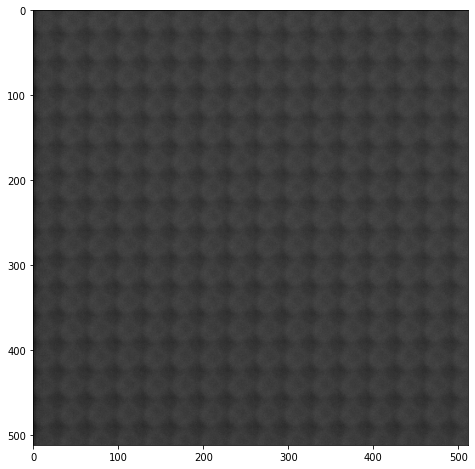

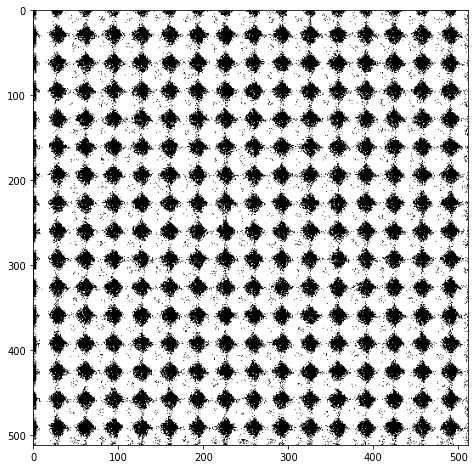

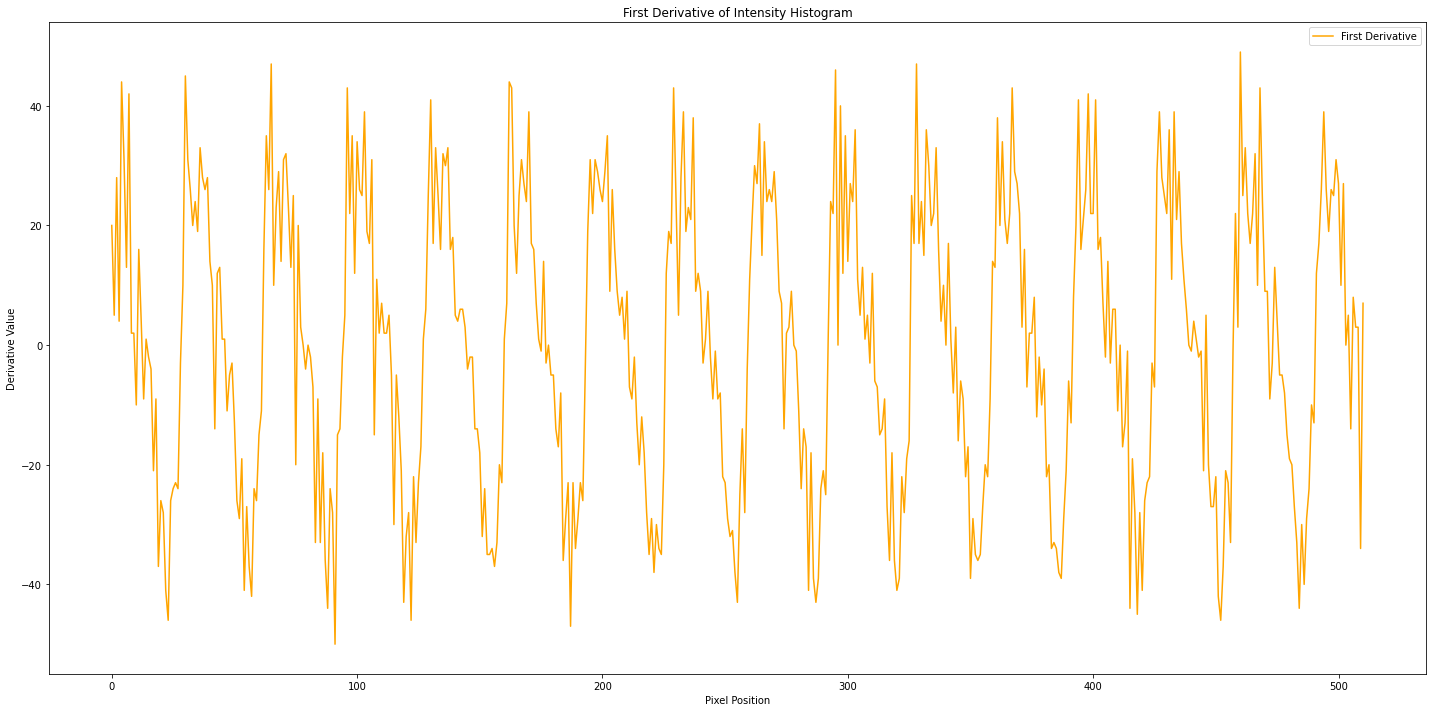

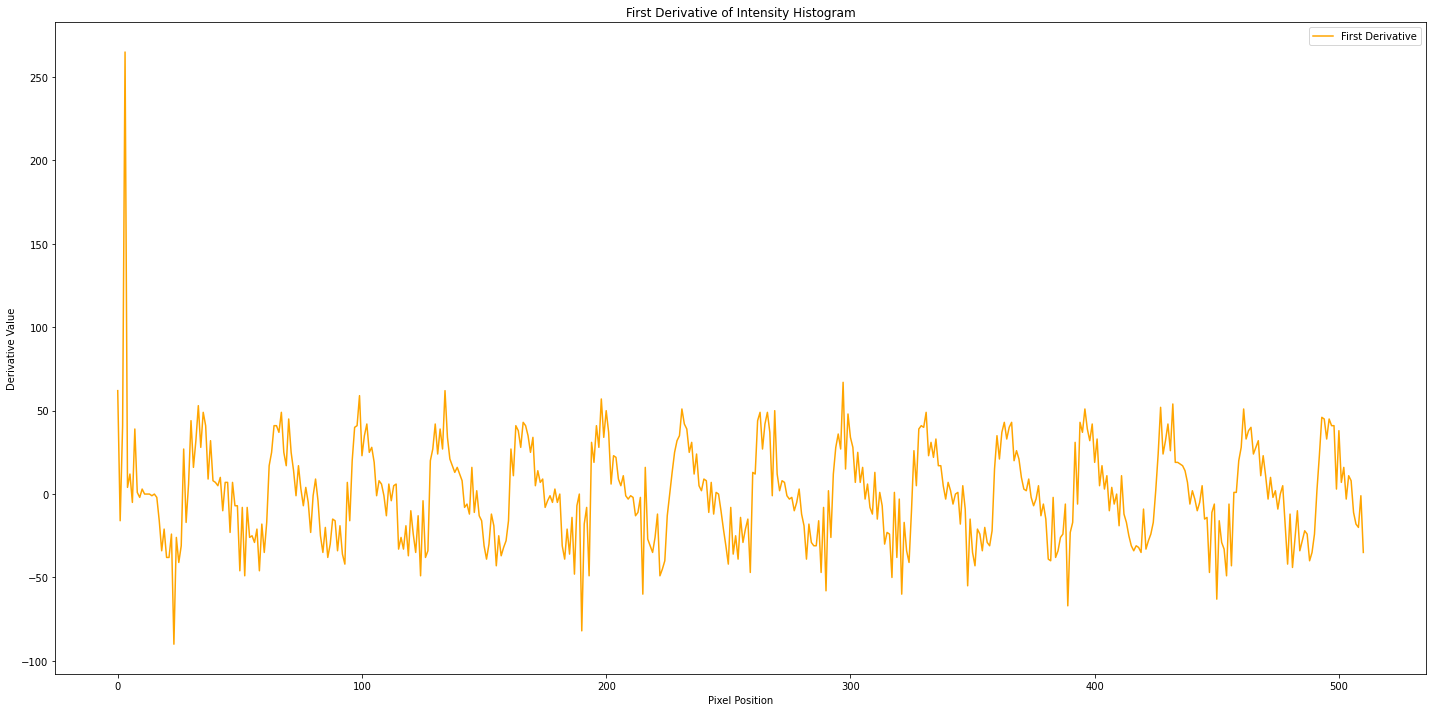

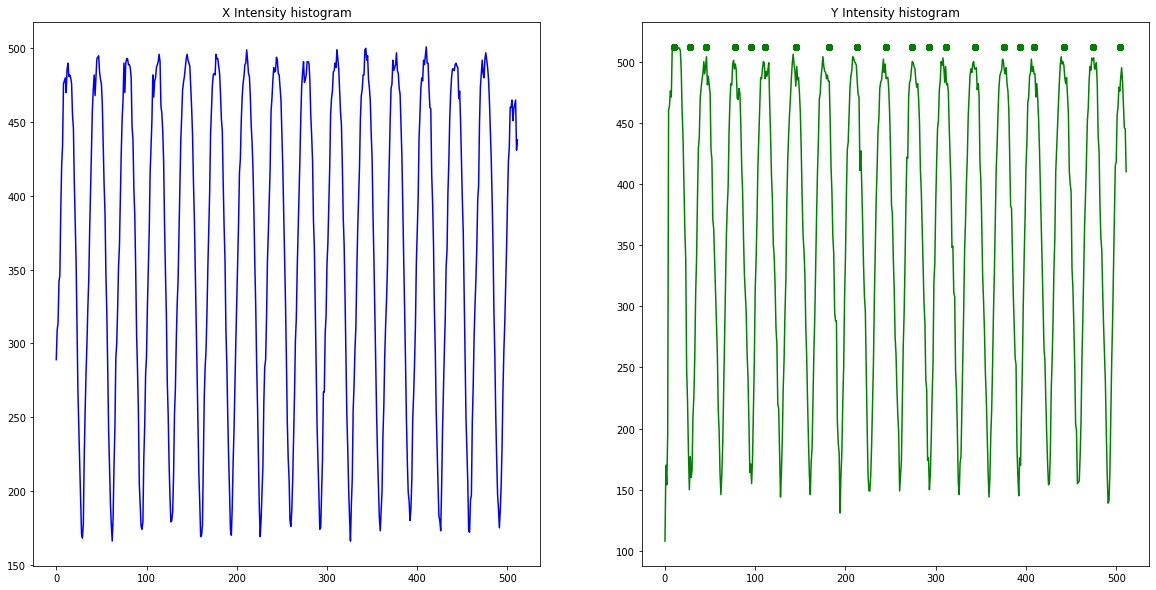

X coordinates
30.12990196078422
60.25980392156844
90.38970588235266
120.51960784313688
150.6495098039211
180.77941176470532
210.90931372548954
241.03921568627376
271.169117647058
301.2990196078422
331.4289215686264
361.55882352941063
391.6887254901948
421.8186274509791
451.9485294117633
482.0784313725475
Y coordinates
26.46516290726815
52.9303258145363
79.39548872180445
105.8606516290726
132.32581453634077
158.79097744360894
185.25614035087705
211.7213032581452
238.18646616541338
264.65162907268154
291.1167919799497
317.5819548872178
344.047117794486
370.51228070175415
396.97744360902226
423.4426065162904
449.9077694235586
476.37293233082676
502.8380952380949


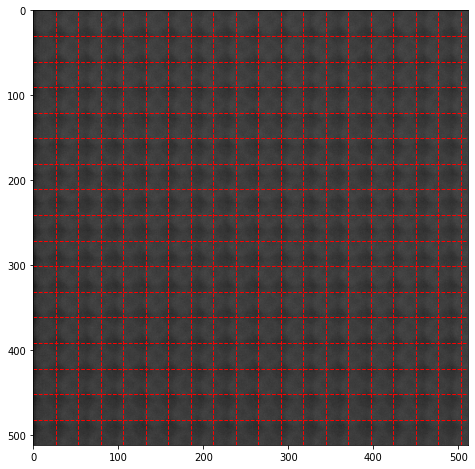

Steps/Mean diameters: dx 30.12990196078422 dy 26.46516290726815
Mean Error:  9.778672217989326


In [25]:
def generate_threshold_img(image, gauss_kernel, block_size, c):
    # Extract the first channel (assuming it's a grayscale image)
    gray = image[:, :, 0]

    # Apply Median blur to reduce noise
    kernel_size = gauss_kernel[0] #  +10
    cv2.medianBlur(gray, kernel_size)
    
    # Apply adaptive thresholding using mean of neighborhood as the threshold value
    # Pixels with values above the threshold become white, and below become black
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)

    # Return the thresholded image
    return thresh

calibrate_svd(im)


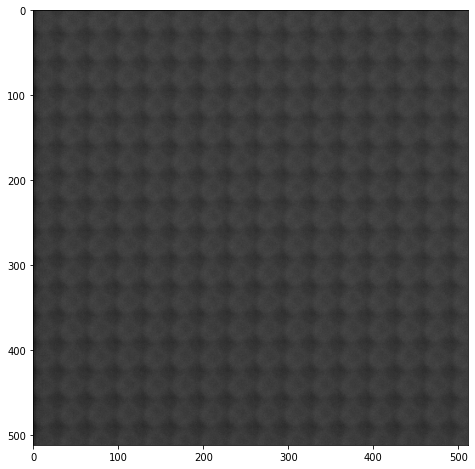

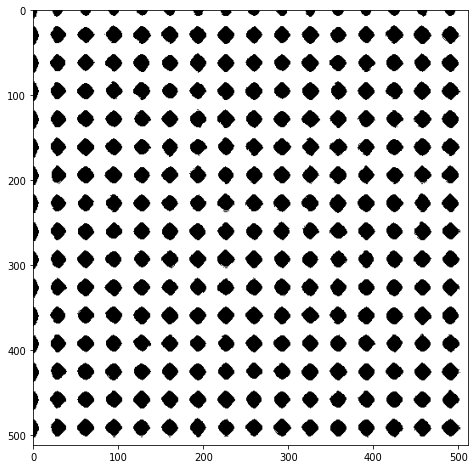

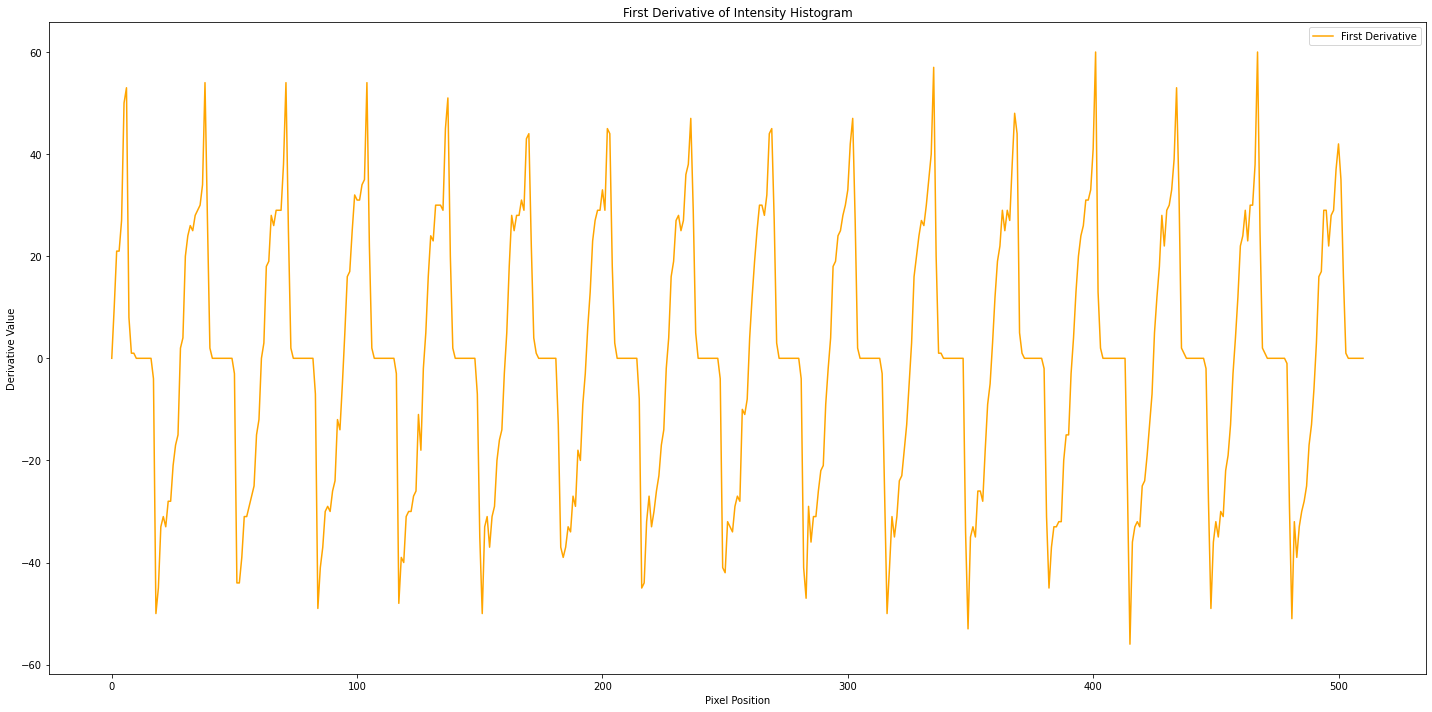

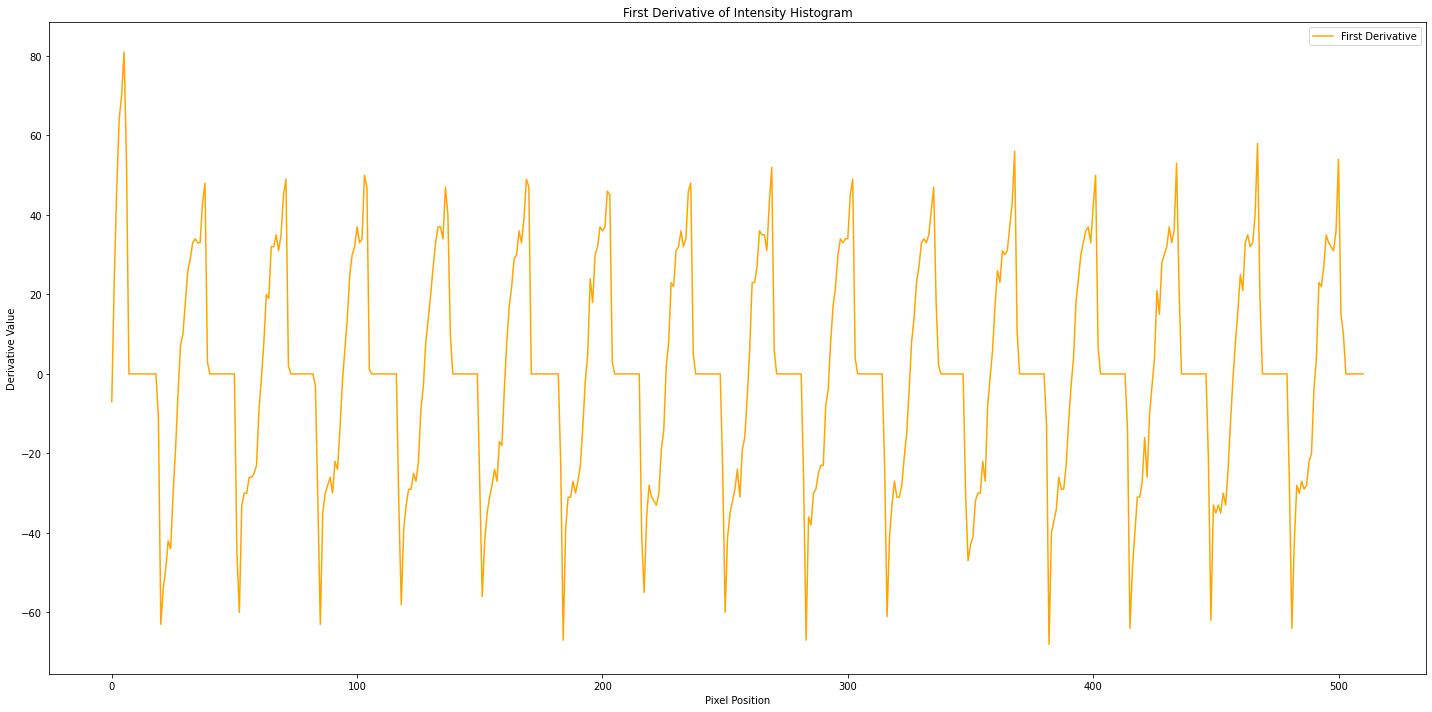

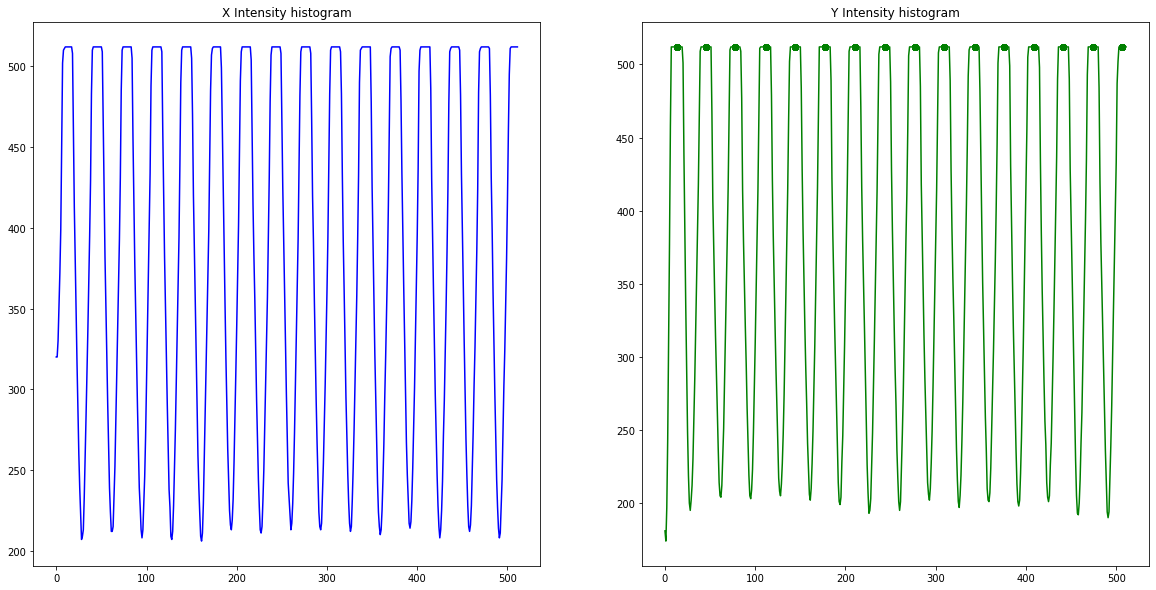

X coordinates
33.0
66.0
99.0
132.0
165.0
198.0
231.0
264.0
297.0
330.0
363.0
396.0
429.0
462.0
495.0
Y coordinates
32.98235294117647
65.96470588235294
98.94705882352942
131.9294117647059
164.91176470588238
197.89411764705886
230.8764705882353
263.8588235294118
296.84117647058827
329.82352941176475
362.80588235294124
395.78823529411767
428.77058823529416
461.75294117647064
494.7352941176471


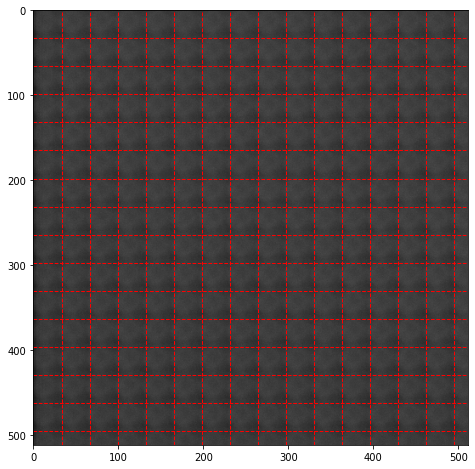

Steps/Mean diameters: dx 33.0 dy 32.98235294117647
Mean Error:  0.4623129490215988


In [26]:
def generate_threshold_img(image, gauss_kernel, block_size, c):
    # Extract the first channel (assuming it's a grayscale image)
    gray = image[:, :, 0]

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, gauss_kernel, 0)
    
    # Apply adaptive thresholding using mean of neighborhood as the threshold value
    # Pixels with values above the threshold become white, and below become black
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)

    # Return the thresholded image
    return thresh

calibrate_svd(im)

### Adaptive Threshold

#### Simple Threshold vs Adaptive Threshold

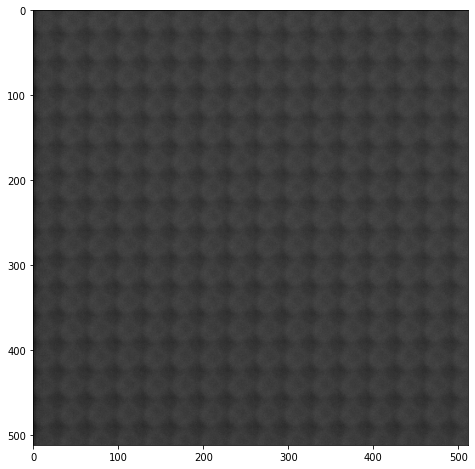

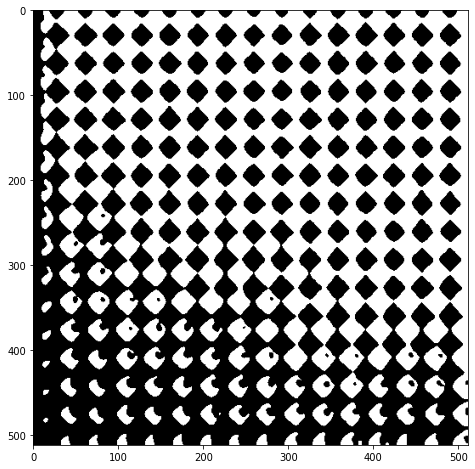

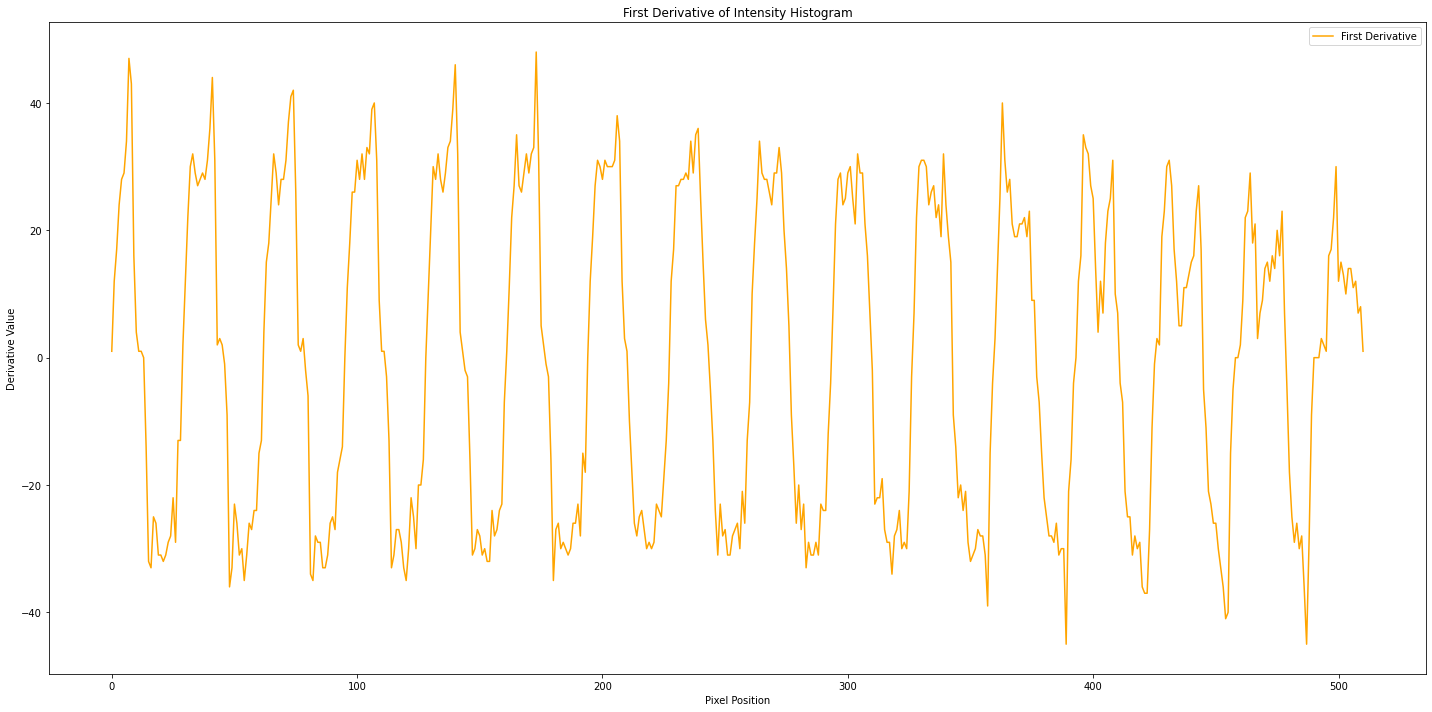

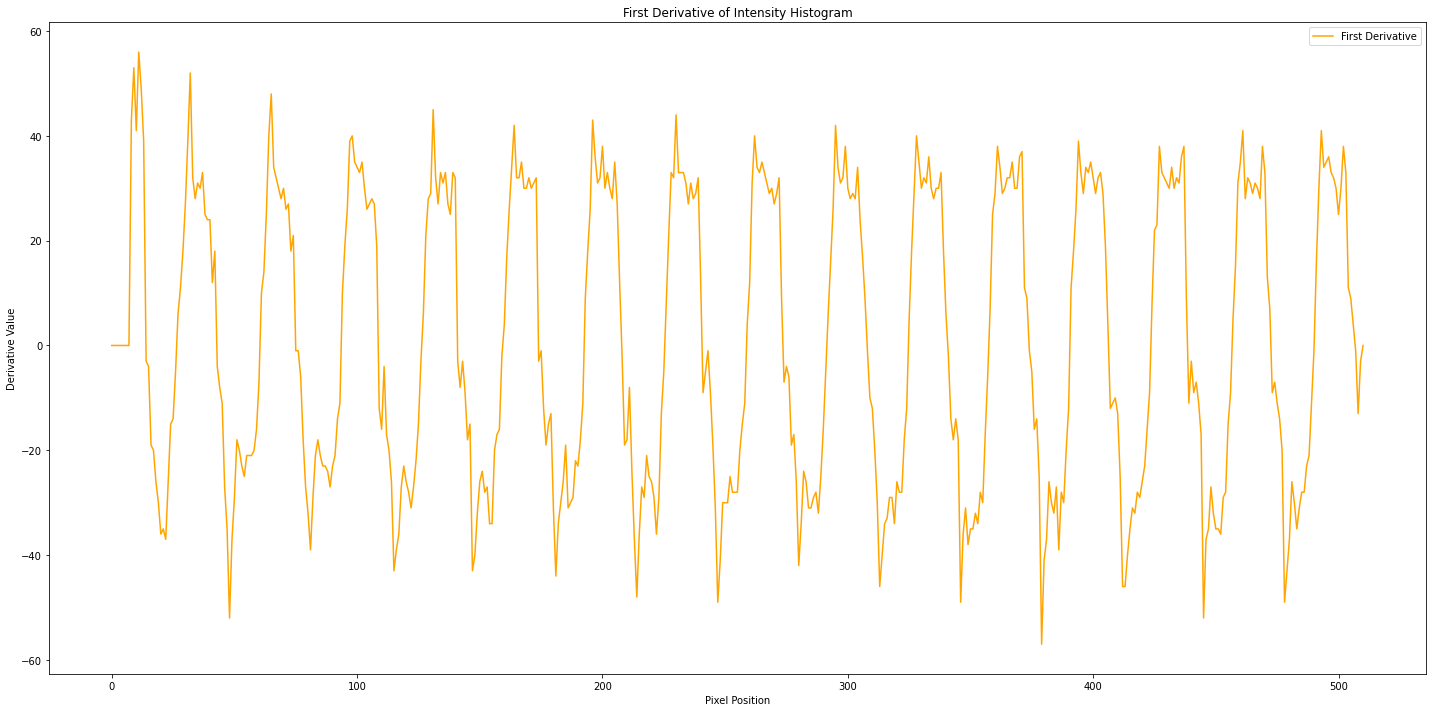

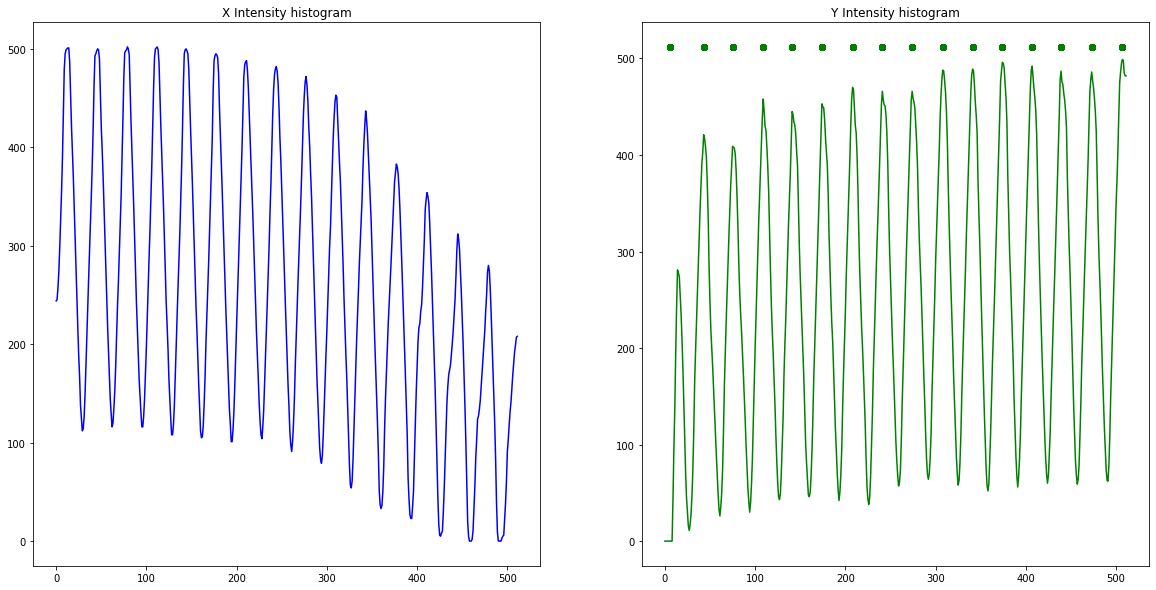

X coordinates
31.367647058823557
62.735294117647115
94.10294117647067
125.47058823529423
156.8382352941178
188.20588235294136
219.5735294117649
250.94117647058846
282.308823529412
313.67647058823553
345.0441176470591
376.41176470588266
407.7794117647062
439.1470588235298
470.5147058823533
501.8823529411769
Y coordinates
33.23713235294123
66.47426470588246
99.71139705882369
132.94852941176492
166.18566176470614
199.42279411764736
232.65992647058863
265.89705882352985
299.13419117647106
332.3713235294123
365.6084558823535
398.84558823529477
432.082720588236
465.3198529411772
498.5569852941185


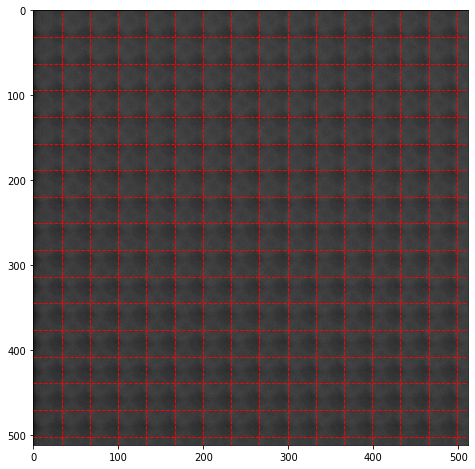

Steps/Mean diameters: dx 31.367647058823557 dy 33.23713235294123
Mean Error:  8.107450095343221


In [49]:
def generate_threshold_img(image, gauss_kernel, block_size, c):
    # Extract the first channel (assuming it's a grayscale image)
    gray = image[:, :, 0]

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, gauss_kernel, 0)
    
    # Pixels with values above the threshold become white, and below become black
    _, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

    # Return the thresholded image
    return thresh

calibrate_svd(im)

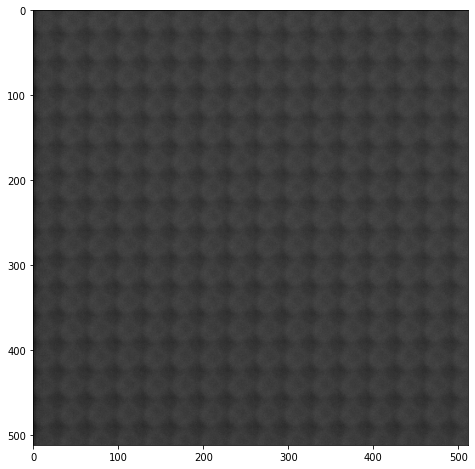

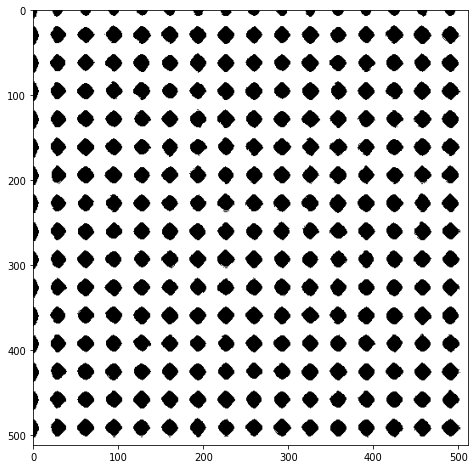

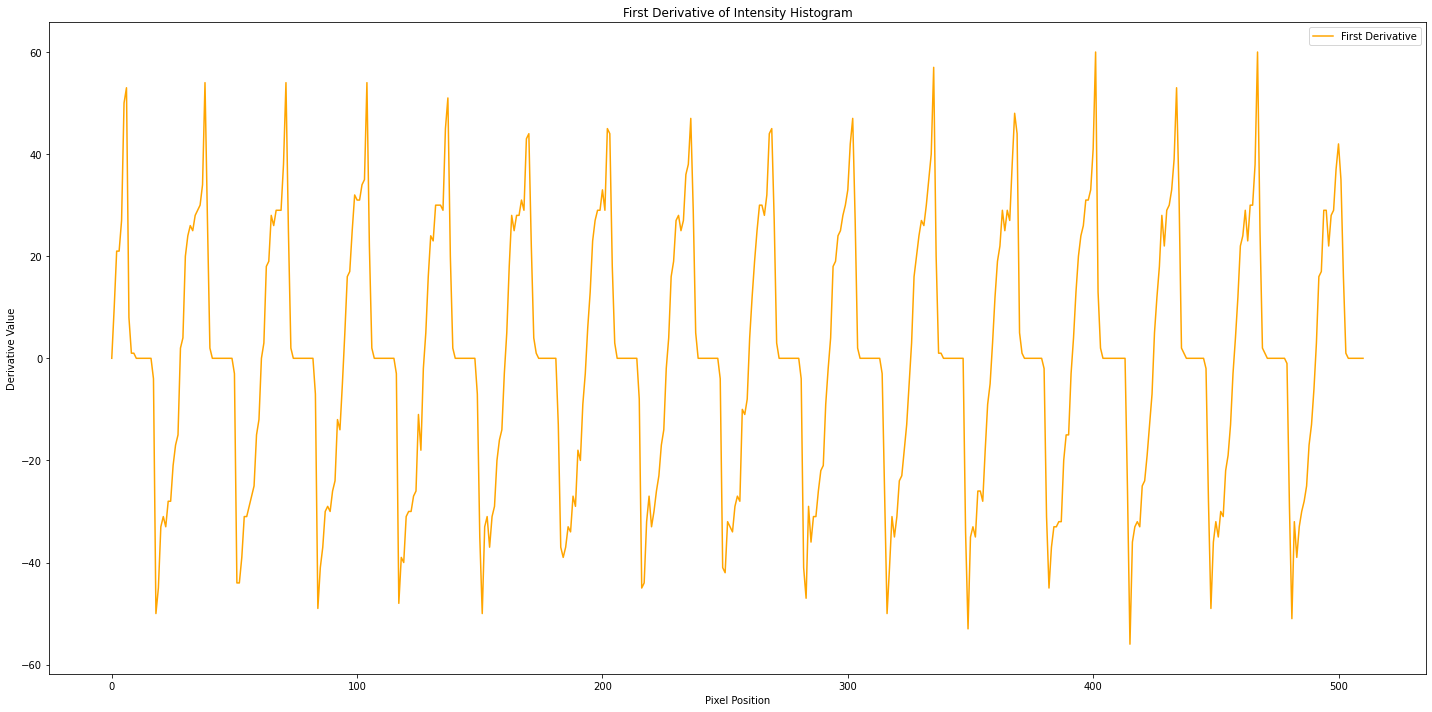

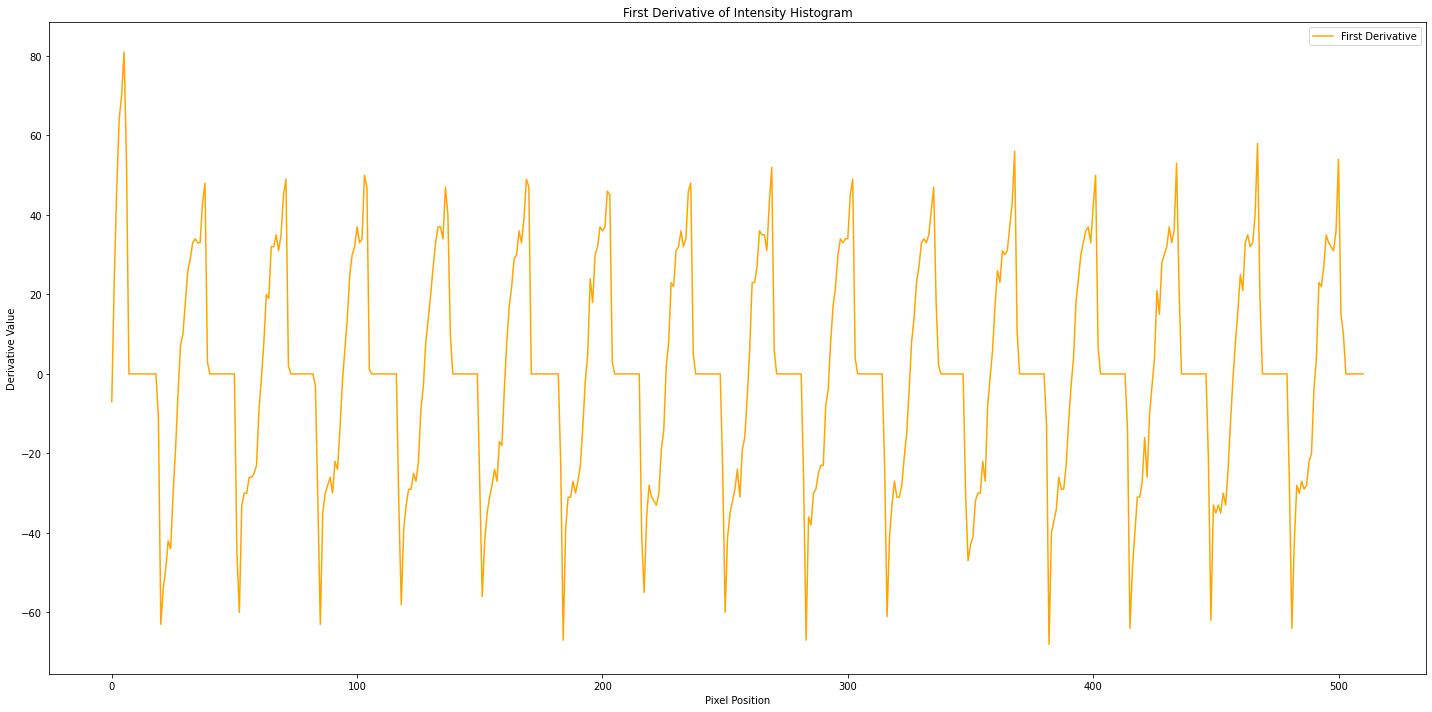

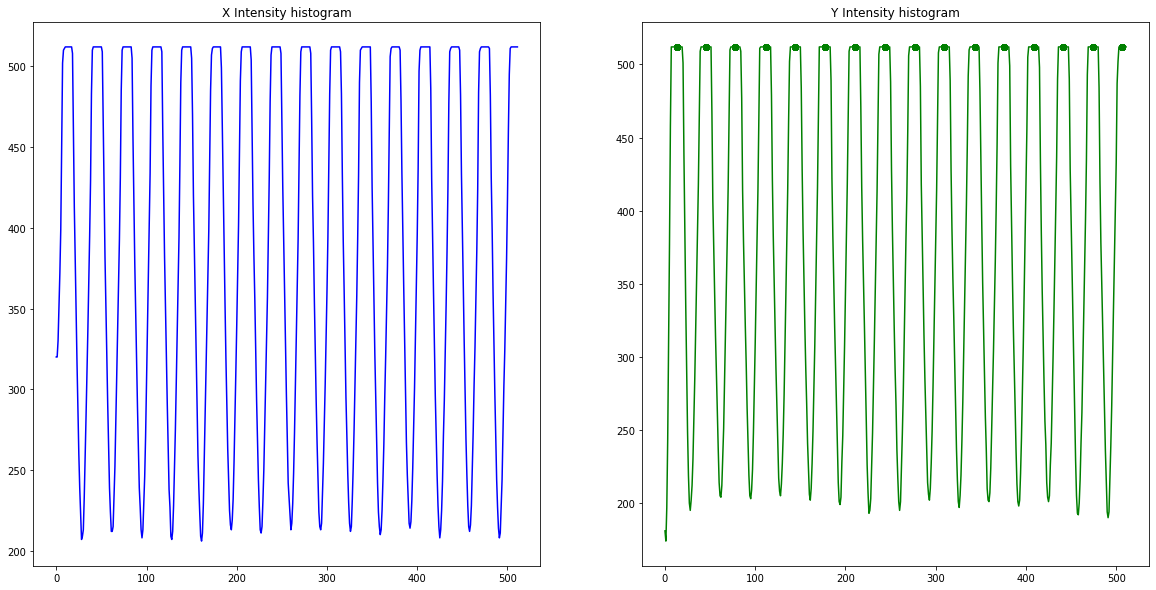

X coordinates
33.0
66.0
99.0
132.0
165.0
198.0
231.0
264.0
297.0
330.0
363.0
396.0
429.0
462.0
495.0
Y coordinates
32.98235294117647
65.96470588235294
98.94705882352942
131.9294117647059
164.91176470588238
197.89411764705886
230.8764705882353
263.8588235294118
296.84117647058827
329.82352941176475
362.80588235294124
395.78823529411767
428.77058823529416
461.75294117647064
494.7352941176471


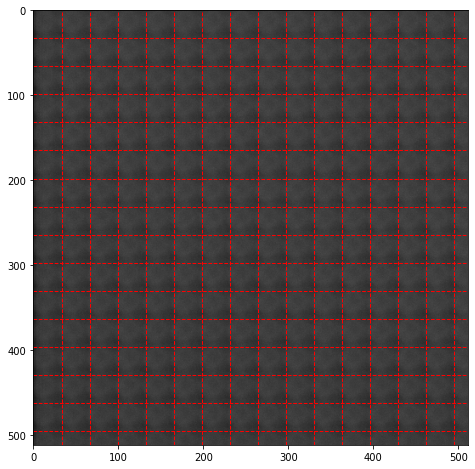

Steps/Mean diameters: dx 33.0 dy 32.98235294117647
Mean Error:  0.4623129490215988


In [50]:
def generate_threshold_img(image, gauss_kernel, block_size, c):
    # Extract the first channel (assuming it's a grayscale image)
    gray = image[:, :, 0]

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, gauss_kernel, 0)
    
    # Apply adaptive thresholding using mean of neighborhood as the threshold value
    # Pixels with values above the threshold become white, and below become black
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, c)

    # Return the thresholded image
    return thresh

calibrate_svd(im)

## Circle Centers Detection

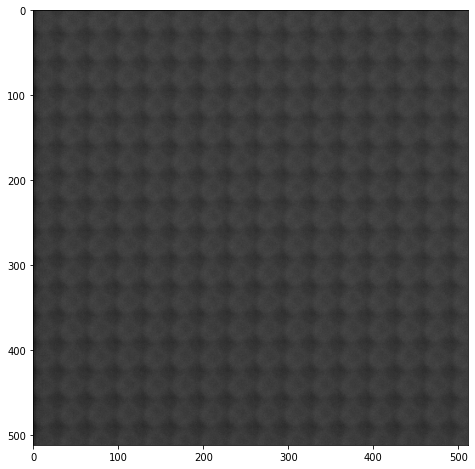

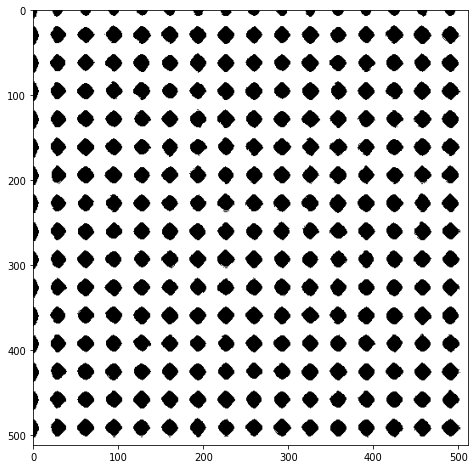

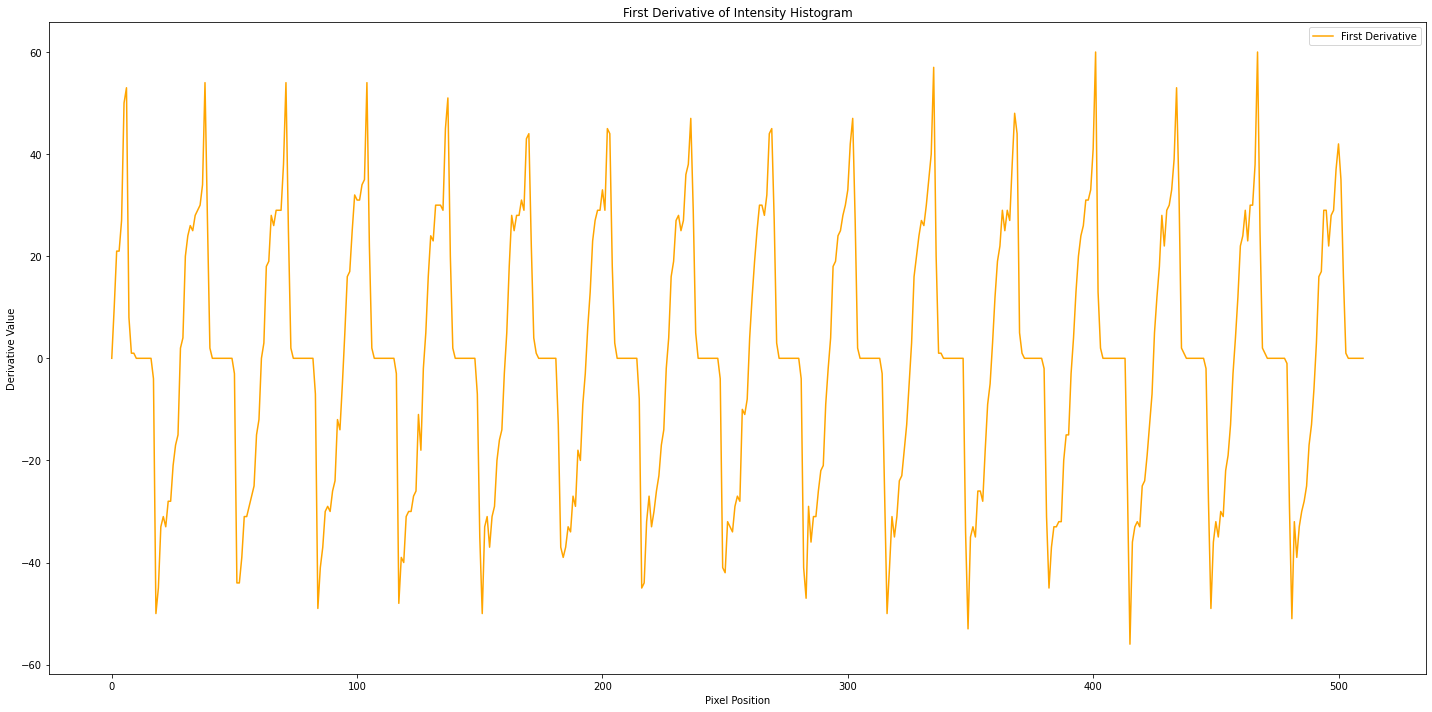

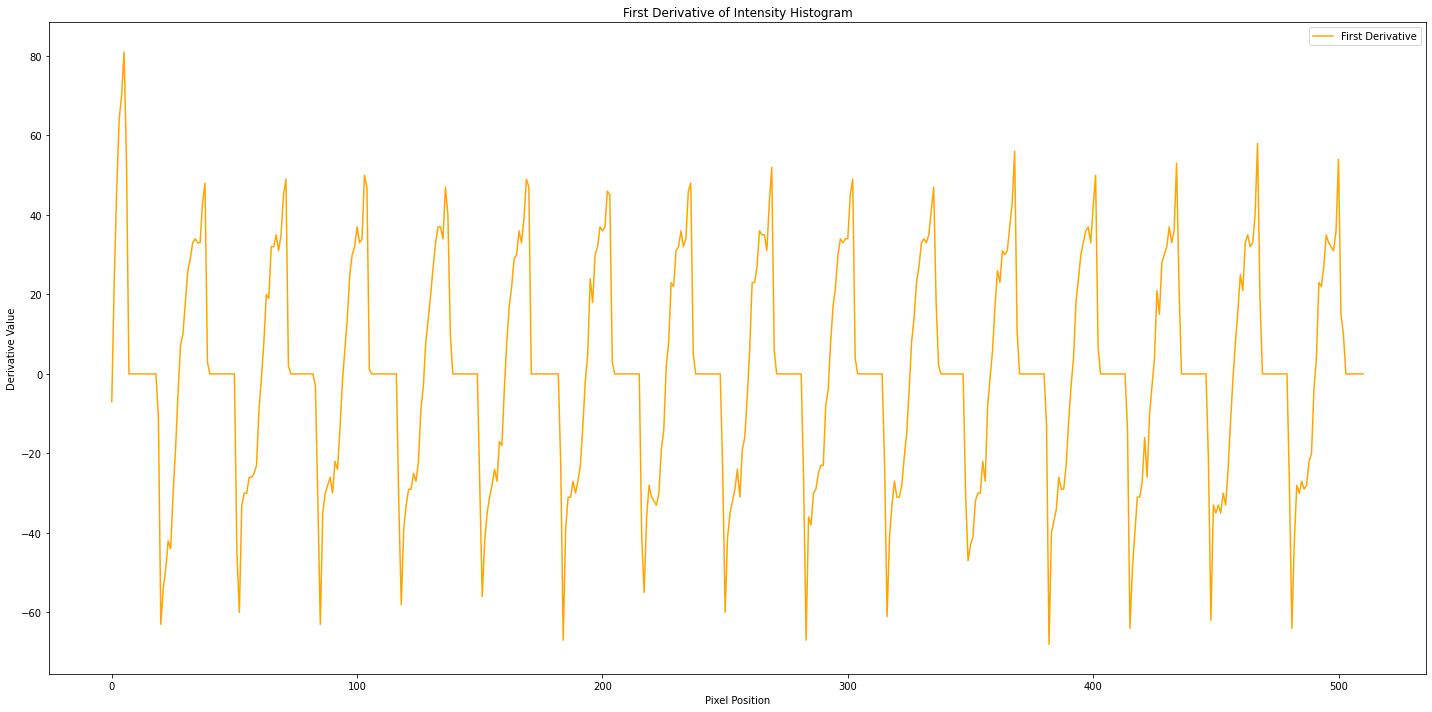

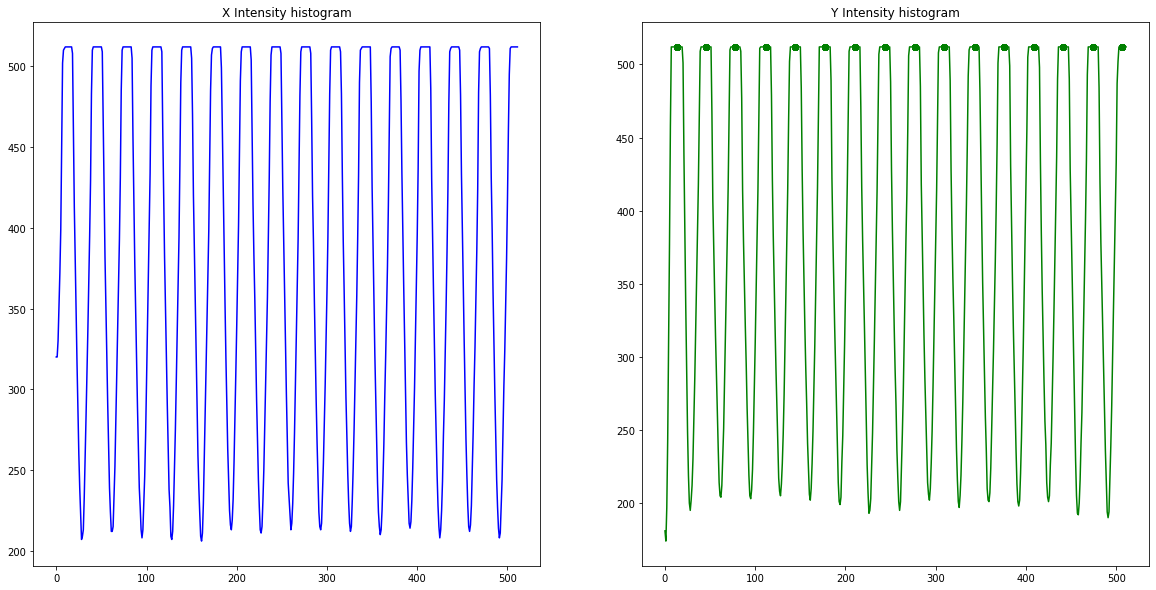

X coordinates
33.0
66.0
99.0
132.0
165.0
198.0
231.0
264.0
297.0
330.0
363.0
396.0
429.0
462.0
495.0
Y coordinates
32.98235294117647
65.96470588235294
98.94705882352942
131.9294117647059
164.91176470588238
197.89411764705886
230.8764705882353
263.8588235294118
296.84117647058827
329.82352941176475
362.80588235294124
395.78823529411767
428.77058823529416
461.75294117647064
494.7352941176471


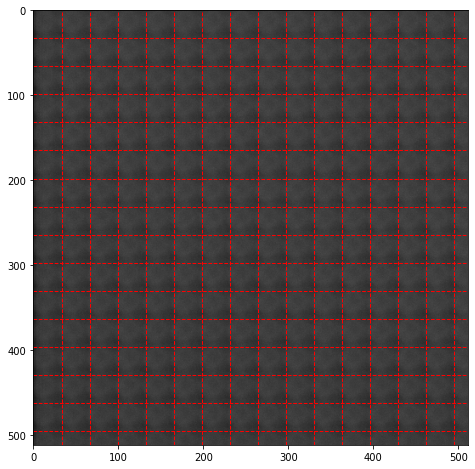

Steps/Mean diameters: dx 33.0 dy 32.98235294117647
Mean Error:  0.4623129490215988


In [51]:
calibrate_svd(im)

## Grid Computation

### Problem Definition

### Algorithm

## Error Computation

### Error Definition & Interpretation

### Algorithm

### Heatmap Construction